# Enunciado — Segmentación Multicriterio

En el video **[YouTube: Señal de paso con prioridad para peatones](https://www.youtube.com/watch?v=b-WViLMs_4c)** se puede observar, **desde el minuto 4:00 al 4:06** (la tarea debe ejecutarse con imágenes cercanas al **minuto 4:04**), una **señal de tráfico que informa de la existencia de un paso con prioridad para peatones**.

## Objetivo
Desarrollar una **solución de segmentación** que, a partir de dicho video, **sea capaz de segmentar la señal**.

## Requisito clave
La solución **debe** emplear una **aproximación multicriterio**: la segmentación debe realizarse con **al menos dos criterios diferentes** (por ejemplo, color + forma, color + textura, bordes + patrones geométricos, etc.).

## Extracción de imágenes (frames)
Para extraer imágenes del video, pueden usar cualquier código presente en la literatura. Como referencia:
- **Tutorial**: [Extract frames from videos in Python — thepythoncode.com](https://www.thepythoncode.com/article/extract-frames-from-videos-in-python)

> Sugerencia: Trabajen con frames cercanos al segundo **4:04** del video.

## Entregables sugeridos (en el notebook)
1. Descripción breve de los **criterios** de segmentación utilizados.
2. **Código** para la extracción de frames.
3. **Implementación** de la segmentación por cada criterio y su **combinación**.
4. **Resultados** (imágenes antes/después) y breve **discusión**.
5. Conclusiones.

---


### 1. Extraer frame deseado

In [ ]:
from datetime import timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

SAVING_FRAMES_PER_SECOND = 1


def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s


def main(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

if __name__ == "__main__":
    import sys
    video_file = sys.argv[1]
    main("video_segment.mp4")

    

### 2. Segmentación Multicriterio

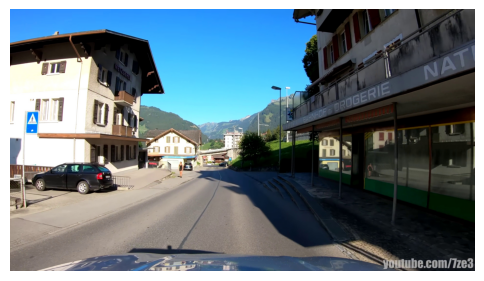

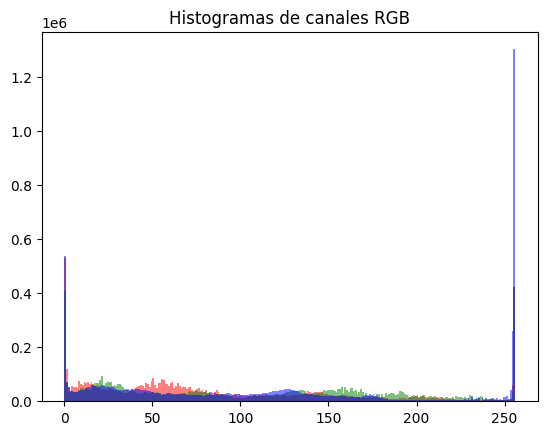

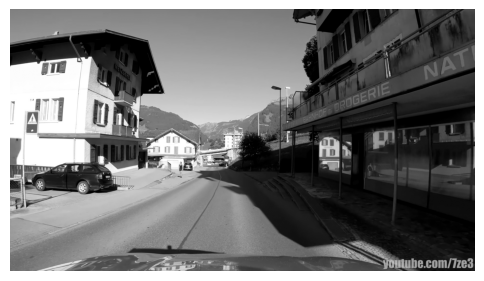

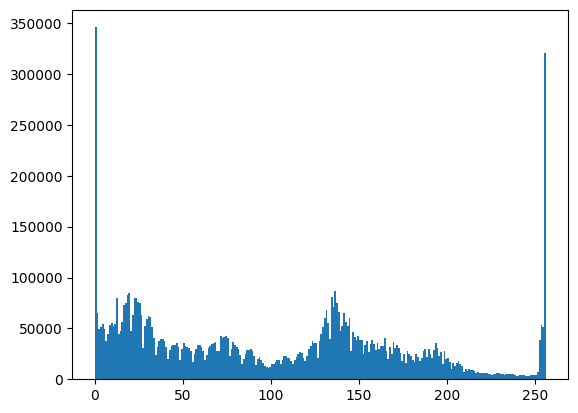

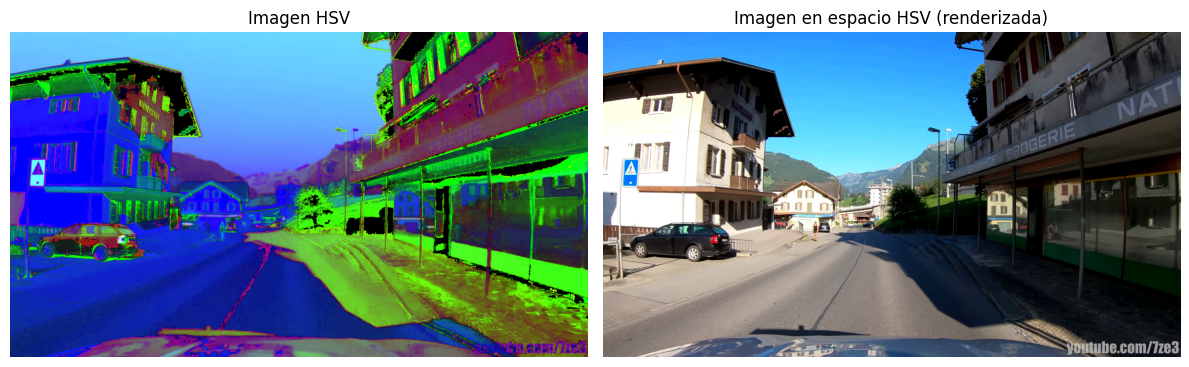

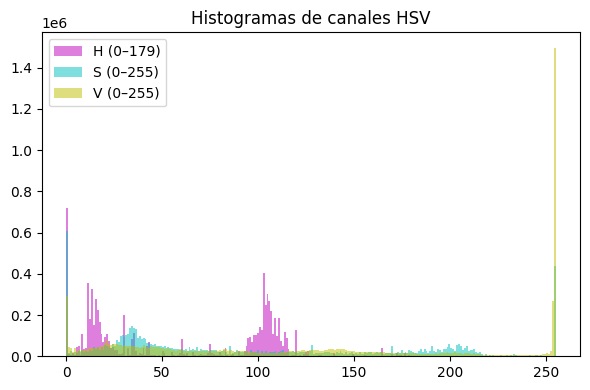

In [14]:
# Segmentación multicriterio

# Segmentación por HSI

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#Para ambas segmentaciones se va a utilizar el frame #1 del segundo 4:05.
im = cv2.imread('video_segment-opencv/frame5.jpg', cv2.IMREAD_COLOR)
assert im is not None, "file could not be read, check with os.path.exists()"
# Convert BGR to RGB for matplotlib
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(im_rgb)
plt.axis('off')
plt.show()

# Mostrar histograma para cada canal de color
colors = ('r','g','b')
for i, col in enumerate(colors):
    plt.hist(im_rgb[:,:,i].ravel(), bins=256, range=(0,256), color=col, alpha=0.5)
plt.title('Histogramas de canales RGB')
plt.show()


imgbw = cv2.imread('video_segment-opencv/frame5.jpg', cv2.IMREAD_GRAYSCALE)
assert imgbw is not None, "file could not be read, check with os.path.exists()"
plt.figure(figsize=(6,6))
plt.imshow(imgbw, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

plt.hist(imgbw.ravel(), bins=256, range=(0,256))
plt.show()




# Convertir la imagen de BGR a HSV
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

# (Opcional) visualizar cómo se vería en RGB al interpretar HSV
im_from_hsv_rgb = cv2.cvtColor(im_hsv, cv2.COLOR_HSV2RGB)

# Mostrar imagen original (RGB) y la imagen en espacio HSV (renderizada) lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(im_hsv)
axs[0].set_title('Imagen HSV')
axs[0].axis('off')

axs[1].imshow(im_from_hsv_rgb)
axs[1].set_title('Imagen en espacio HSV (renderizada)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Mostrar histograma para cada canal de HSV
colors_hsv = ('m', 'c', 'y')      # magenta, cyan, amarillo (válidos)
labels_hsv = ('H', 'S', 'V')

# Nota: en OpenCV H va de 0 a 179, S y V de 0 a 255
H, S, V = im_hsv[:,:,0], im_hsv[:,:,1], im_hsv[:,:,2]

plt.figure(figsize=(6,4))
plt.hist(H.ravel(), bins=180, range=(0,179), color=colors_hsv[0], alpha=0.5, label='H (0–179)')
plt.hist(S.ravel(), bins=256, range=(0,255), color=colors_hsv[1], alpha=0.5, label='S (0–255)')
plt.hist(V.ravel(), bins=256, range=(0,255), color=colors_hsv[2], alpha=0.5, label='V (0–255)')
plt.title('Histogramas de canales HSV')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Ahora se procede con el objetivo de segmentar la imagen con base en los valores de H S V.
# Definir umbrales para H, S, V
